In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
SEED = 5080

In [3]:
GDSC_data = pd.read_csv("./GDSC_PDX_Gemcitabine/GDSC_PDX_Gemcitabine.csv")
GDSC_patient = pd.read_csv("./GDSC_PDX_Gemcitabine/Patients_PDX_Gemcitabine.csv")

In [4]:
GDSC_data = GDSC_data.rename(columns = {'Unnamed: 0': 'gene_expression'})
GDSC_data = GDSC_data.dropna()
GDSC_patient = GDSC_patient.rename(columns = {'Unnamed: 0': 'patient_id'})

# EDA

In [5]:
print(f"Training dataset shape = {GDSC_data.shape}")
print(f"Testing dataset shape = {GDSC_patient.shape}")

Training dataset shape = (866, 16192)
Testing dataset shape = (25, 16192)


In [6]:
if list(GDSC_data.columns[2:]) == list(GDSC_patient.columns[2:]):
    print("All features in training and testing dataset are the same!")
else:
    print("There are some different features in testing dataset")

All features in training and testing dataset are the same!


In [7]:
MAX_MEDICINE_LEVEL = 1.024
GDSC_data["target"] = GDSC_data["IC50"].apply(
    lambda x: "R" if x > MAX_MEDICINE_LEVEL else "S"
    )

In [8]:
ratio = GDSC_data["target"].value_counts() / GDSC_data.shape[0]
print("Label distribution in TCGA dataset")
print(ratio * 100)

Label distribution in TCGA dataset
S    78.52194
R    21.47806
Name: target, dtype: float64


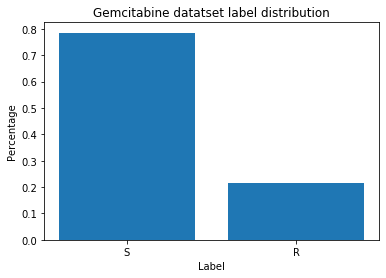

In [9]:
plt.xlabel("Label")
plt.ylabel("Percentage")
plt.title("Gemcitabine datatset label distribution")
plt.bar(x = ratio.index, height=ratio)
plt.show()

# Data preprocessing

In [10]:
drop_cols = ["IC50", "gene_expression", "target"]
keep_cols = list(
    set(GDSC_data.columns) - set(drop_cols)
)
X = GDSC_data[keep_cols]
y = GDSC_data["target"]

In [11]:
print(X.shape)
print(y.shape)

(866, 16190)
(866,)


# Feature selection

### Logistic regression with L1 regularization

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

In [ ]:
clf = LogisticRegressionCV(
    cv=3, penalty = "l1", solver="saga", random_state=SEED
    ).fit(X, y)

In [ ]:
acc = clf.score(X, y)
print(f"Training acc of best model = {round(acc * 100, 4)}%")
print("Cross Validation result in each parameter sets")
pd.DataFrame({"C":clf.Cs_, "Cross valid acc": clf.scores_["S"].mean(axis = 0)})

In [ ]:
logistic_regression_coefs = X.columns[(clf.coef_ > 0).flatten()]
print(f"There are {len(logistic_regression_coefs)} features selected by L1 logistic regression")
print(sorted(logistic_regression_coefs.tolist()))

## Anova F-test

In [12]:
anova_selector = SelectKBest(score_func=f_classif, k=30)
anova_selector.fit(X, y)

SelectKBest(k=30, score_func=<function f_classif at 0x0000020EB93D3158>)

In [13]:
num_selected_features = 30
anova_df = pd.DataFrame({"feature_names":X.columns, "scores":anova_selector.scores_})
anova_df = anova_df.sort_values(by = ["scores"], ascending=False)
print(f"Top {num_selected_features} selected by anova classification are")
print(anova_df[:num_selected_features]["feature_names"].tolist())
anova_df[:num_selected_features]

Top 30 selected by anova classification are
['CCT4', 'SLFN11', 'HDAC11', 'ANP32B', 'MTHFD1L', 'DIMT1', 'NPM3', 'TFF3', 'DYNLRB2', 'SYT7', 'ATP6AP1', 'PPWD1', 'PRR15L', 'MGP', 'PPP1R3D', 'NOB1', 'MB', 'BTAF1', 'MAT2B', 'SNHG1', 'RPS12', 'RPL11', 'PBX1', 'PIP', 'LYAR', 'IGFBP5', 'GUK1', 'USP45', 'TAF1D', 'SNX5']


,feature_names,scores
15686,CCT4,45.206014
8357,SLFN11,44.220641
10023,HDAC11,43.189675
6146,ANP32B,42.165937
15471,MTHFD1L,39.083657
2947,DIMT1,38.228596
7023,NPM3,37.940679
12959,TFF3,34.555176
7516,DYNLRB2,33.314471
237,SYT7,33.039393


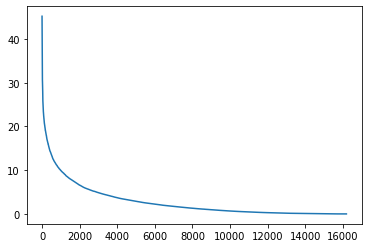

In [14]:
x = [i for i in range(len(anova_df["scores"]))]
plt.plot(x, anova_df["scores"])
plt.show()

## Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
RF_params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'oob_score': [True]}
print(RF_params_grid)

In [ ]:
RFC = RandomForestClassifier(random_state = SEED)
# RFC_CV = GridSearchCV(estimator = RFC, param_grid = params_grid, cv = cv, verbose = 2, n_jobs = -1)
RFC_CV = RandomizedSearchCV(
    n_iter = 30, estimator = RFC, param_distributions = RF_params_grid, 
    cv = cv, verbose = 2, n_jobs = -1
)
RFC_CV.fit(X, y)

In [ ]:
num_selected_features = 30
RF_df = pd.DataFrame(
    {"feature_names":X.columns, "feature_importances":RFC_CV.best_estimator_.feature_importances_}
)
RF_df = RF_df.sort_values(by = ["feature_importances"], ascending=False)
print(f"Top {num_selected_features} selected by RF classification are")
print(RF_df[:num_selected_features]["feature_names"].tolist())

In [ ]:
threshold = 0.001
features = RF_df[RF_df["feature_importances"] > threshold]["feature_names"].tolist()
print(f"There are {len(features)} features selected by threshold {threshold}")
print(RF_df[RF_df["feature_importances"] > threshold]["feature_names"].tolist())

In [ ]:
x = [i for i in range(X.shape[1])]
plt.plot(x, RF_df["feature_importances"])
plt.xlabel("Features sorted by features importance")
plt.ylabel("Feature importance")
plt.show()

# Data preprocessing for selected features

In [ ]:
L1_features = []
Anova_features = [
    'CCT4', 'SLFN11', 'HDAC11', 'ANP32B', 
    'MTHFD1L', 'DIMT1', 'NPM3', 'TFF3', 
    'DYNLRB2', 'SYT7', 'ATP6AP1', 'PPWD1', 
    'PRR15L', 'MGP', 'PPP1R3D', 'NOB1', 'MB', 
    'BTAF1', 'MAT2B', 'SNHG1', 'RPS12', 'RPL11', 
    'PBX1', 'PIP', 'LYAR', 'IGFBP5', 'GUK1', 
    'USP45', 'TAF1D', 'SNX5'
]

RF_features = [
    'CCT4', 'CLPX', 'TFF3', 'SLFN11', 'VAPB', 'ZNF552', 'TCTA', 
    'TFB1M', 'NACA', 'ZNF121', 'CCNB1IP1', 'COL10A1', 'PPDPF', 
    'GRHL1', 'ALDH3B2', 'SLC9A7', 'RCC1', 'CDH1', 'NELFCD', 'DIMT1', 
    'ZBTB7C', 'ANP32B', 'HS3ST6', 'GUK1', 'CPQ', 'VEGFB', 'PANK2', 
    'NMI', 'MAGED2', 'CERS6'
]

L1_set = set(L1_features)
Anova_set = set(Anova_features)
RF_set = set(RF_features)

union_features = L1_set | Anova_set | RF_set
intersect_features = L1_set & Anova_set & RF_set
print(f"Number of union features = {len(union_features)}")
print(f"Number of intersect features = {len(intersect_features)}")

In [ ]:
final_features = list(union_features)
X_train = GDSC_data[final_features]
y_train = GDSC_data["target"]
X_test = GDSC_patient[final_features]
y_test = GDSC_patient["label"]

SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Modeling

### Level One Model - hyperparameter tuning
- Ridge Regression
- Random Forest
- XGboost
- Support Vector Machine
- KNN

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

In [ ]:
#Ridge regression 
clf_LG = LogisticRegressionCV(
    cv=cv, penalty = "l2", random_state=SEED
    ).fit(X_train, y)
clf_LG.score(X_train, y_train)

In [ ]:
#Random forest
RFC = RandomForestClassifier(random_state = SEED)
RFC_CV = GridSearchCV(
    estimator = RFC, param_grid = RF_params_grid, 
    cv = cv, verbose = 1, n_jobs = -1
    )
RFC_CV.fit(X_train, y_train)

In [ ]:
import pickle
with open('RF_clf.pickle', 'wb') as f:
    pickle.dump(RFC_CV, f)

In [ ]:
#SVM
SVM_param_grid = {
    'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

SVC_clf = SVC()
SVC_grid = GridSearchCV(SVC_clf, SVM_param_grid, refit=True, verbose=1)
SVC_grid.fit(X_train, y_train)

In [ ]:
#KNN
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(3, k_max, 3))
KNN_param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

KNN = KNeighborsClassifier()
KNN_grid = GridSearchCV(KNN, 
    KNN_param_grid, 
    verbose = 1,
    cv = cv, n_jobs = -1).fit(X_train, y_train)

# Stacking model

In [ ]:
L2REG = LogisticRegression(C = clf_LG.C_[0], penalty = "l2")
RF = RandomForestClassifier(**RFC_CV.best_params_, random_state = SEED)
SVM = SVC(**SVC_grid.best_params_)
KNN = KNeighborsClassifier(**KNN_grid.best_params_)
base_learners = [
    ("Ridge", L2REG),
    ("RF", RF),
    ("SVM", SVM),
    ("KNN", KNN)
]
stack_clf = StackingClassifier(
    estimators = base_learners, 
    final_estimator = LogisticRegression(),
    cv = 10,
    n_jobs = -1,
    verbose = 1
)
stack_clf.fit(X_train, y)

In [ ]:
train_acc = stack_clf.score(X_train, y_train)
print(f"Training accuracy of stack classifier = {train_acc}")

In [ ]:
stack_clf.classes_

# Inference

In [ ]:
# y_train_pred = stack_clf.decision_function(X_train)
# y_test_pred = stack_clf.decision_function(X_test)
y_train_pred = stack_clf.predict_proba(X_train)[:, 1]
y_test_pred = stack_clf.predict_proba(X_test)[:, 1]

In [ ]:
y_train_trans = [0 if i == "R" else 1 for i in y_train]

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_trans, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(1 - y_test, y_test_pred)

train_AUC = auc(train_fpr, train_tpr)
test_AUC = auc(test_fpr, test_tpr)

plt.plot(
    train_fpr, train_tpr, 
    label = f"Training AUC={round(train_AUC, 3)}"
    )
plt.plot(
    test_fpr, test_tpr, 
    label = f"Testing AUC={round(test_AUC, 3)}"
    )
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Gemcitabine dataset)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()